In [19]:
from lightgbm import LGBMClassifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

In [20]:
# Definition of paths
data_dir = os.path.join(os.getcwd(), '../Dataset')

raw_data_dir = os.path.join(data_dir, 'raw')
ids_mapping = os.path.join(raw_data_dir, 'IDS_mapping.csv')
diabetes_data = os.path.join(raw_data_dir, 'diabetic_data.csv')

mapping_data_dir = os.path.join(data_dir, 'Mapping')
os.makedirs(mapping_data_dir, exist_ok=True)

preprocessed_out_dir = os.path.join(data_dir, 'Preprocessed')
os.makedirs(preprocessed_out_dir, exist_ok=True)

admission_type_mapping_data = os.path.join(mapping_data_dir, 'admission_type_mapping.csv')
discharge_disposition_data = os.path.join(mapping_data_dir, 'discharge_disposition_mapping.csv')
admission_source_mapping_data = os.path.join(mapping_data_dir, 'admission_source_mapping.csv')

preprocessed_saved_filepath = os.path.join(preprocessed_out_dir, 'preprocessed.pkl')

In [21]:
df = pd.read_pickle(preprocessed_saved_filepath)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              69987 non-null  int64   
 1   patient_nbr               69987 non-null  int64   
 2   race                      69987 non-null  category
 3   gender                    69987 non-null  object  
 4   age                       69987 non-null  object  
 5   admission_type_id         69987 non-null  category
 6   discharge_disposition_id  69987 non-null  category
 7   admission_source_id       69987 non-null  category
 8   time_in_hospital          69987 non-null  int64   
 9   medical_specialty         69987 non-null  category
 10  num_lab_procedures        69987 non-null  int64   
 11  num_procedures            69987 non-null  int64   
 12  num_medications           69987 non-null  int64   
 13  number_outpatient         69987 non-null  int64   

In [23]:
print(df.dtypes)

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                        object
age                           object
admission_type_id           category
discharge_disposition_id    category
admission_source_id         category
time_in_hospital               int64
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum                  int64
A1Cresult                      int64
metformin                      int64
repaglinide                    int64
glimepiride                    int64
glipizide                      int64
glyburide                      int64
p

In [24]:
for col in df.columns:
    if 'gender' in col:
        df[col] = df[col].astype('category')

In [25]:
df["readmitted"] = df["readmitted"].map({"YES": 1, "NO": 0})

In [26]:
df.drop(columns=["encounter_id", "patient_nbr", "age", "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "glimepiride", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", "insulin"], inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69987 entries, 0 to 101765
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69987 non-null  category
 1   gender                    69987 non-null  category
 2   admission_type_id         69987 non-null  category
 3   discharge_disposition_id  69987 non-null  category
 4   admission_source_id       69987 non-null  category
 5   time_in_hospital          69987 non-null  int64   
 6   medical_specialty         69987 non-null  category
 7   num_lab_procedures        69987 non-null  int64   
 8   num_procedures            69987 non-null  int64   
 9   num_medications           69987 non-null  int64   
 10  number_outpatient         69987 non-null  int64   
 11  number_emergency          69987 non-null  int64   
 12  number_inpatient          69987 non-null  int64   
 13  diag_1                    69987 non-null  category

In [28]:
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

[LightGBM] [Info] Number of positive: 22809, number of negative: 33180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 55989, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407384 -> initscore=-0.374792
[LightGBM] [Info] Start training from score -0.374792
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
Accuracy: 0.63
Precision: 0.58
Recall: 0.36
F1 Score: 0.44


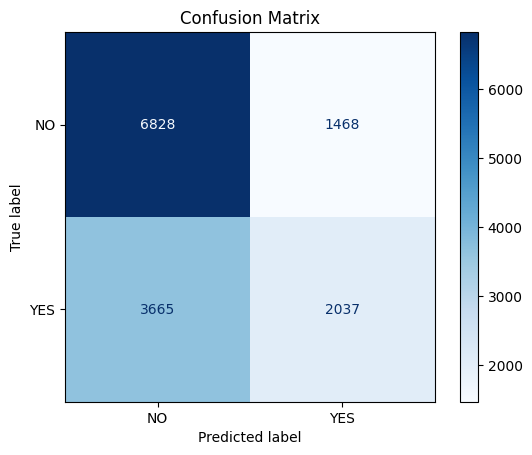

In [30]:
categorical_cols = X.select_dtypes(include=["category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

numerical_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(random_state=42))
])

param_grid = {
    "classifier__num_leaves": [15, 31, 63],  
    "classifier__learning_rate": [0.01, 0.1, 0.2],  
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [5, 10, 15]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

evaluate_model(best_model, X_test, y_test)